# Imports

In [ ]:
import nltk
from nltk.tokenize import word_tokenize

import sys, re, os
import string, unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils import data

import random
from datetime import datetime

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Google drive and Config

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive_path = "/content/drive/MyDrive/Sequence-Analysis-Projects"
translation_path = os.path.join(drive_path, 'translation')
if not os.path.exists(drive_path):
    os.mkdir(drive_path)

projects = ['translation', 'twitter-chatbot']
for project in projects:
    project_path = os.path.join(drive_path, project)
    if not os.path.exists(project_path):
        os.mkdir(project_path)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# some configuration
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 20_000
NUM_SAMPLES = 150_000 # max_num = 192341 
EMBEDDING_DIM = 100
BATCH_SIZE = 64
LATENT_DIM = 256

bos = "<bos>"
eos = "<eos>"
pad = "<pad>"
unk = "<unk>"


#Utils

In [ ]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

In [ ]:
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

# Original Text Preprocessing

In [ ]:
# load in the data
input_texts = []  # sentence in original language
target_texts = []  # sentence in target language
t = 0
for line in open(os.path.join(translation_path, "fra.txt")):
    # only keep a limited number of samples
    t += 1
    if t > NUM_SAMPLES:
        break
    line = line.rstrip()
    # input and targets are separeted by tab
    if "\t" not in line:
        continue

    # split up the input and translation
    input_text, target_text = line.split("\t")[:2]
    input_text, target_text = normalizeString(input_text), normalizeString(target_text)
  
    input_texts.append(input_text)
    target_texts.append(target_text)
    
print("num samples:", len(input_texts))

num samples: 150000


# Build train and test dataset

In [ ]:
N = len(input_texts)
indices = np.random.permutation(N)

N_train = 4 * N // 5

train_indices = list(indices[:N_train])
test_indices = list(indices[N_train:])

train_inputs = [input_texts[i] for i in train_indices]
train_targets = [target_texts[i] for i in train_indices]

test_inputs = [input_texts[i] for i in test_indices]
test_targets = [target_texts[i] for i in test_indices]


print("len(train_inputs):", len(train_inputs))
print("len(test_inputs):", len(test_inputs))

len(train_inputs): 120000
len(test_inputs): 30000


# Build Vocab

In [ ]:
def build_vocab(data):
    vocab = []
    for sentence in data:
        sentence_tokenized = word_tokenize(sentence)
        for word in sentence_tokenized:
            if word not in vocab:
                vocab.append(word)

    return vocab

In [ ]:
#english_vocab = build_vocab(input_texts)
english_vocab = build_vocab(train_inputs)
print(f"There is {len(english_vocab)} token in english_vocab")

There is 10660 token in english_vocab


In [ ]:
#french_vocab = build_vocab(target_texts)
french_vocab = build_vocab(train_targets)
print(f"There is {len(french_vocab)} token in french_vocab")

There is 17498 token in french_vocab


In [ ]:
english_vocab = [pad, unk, bos, eos] + english_vocab
french_vocab = [pad, unk, bos, eos] + french_vocab

In [ ]:
word2idx_eng = {}
for i in range(len(english_vocab)):
    word2idx_eng[english_vocab[i]] = i

word2idx_fr = {}
for i in range(len(french_vocab)):
    word2idx_fr[french_vocab[i]] = i

# map indexes back into real words
# so wwe can view the results
idx2word_eng = {v: w for w, v in word2idx_eng.items()}
idx2word_trans = {v: w for w, v in word2idx_fr.items()}

# Build Sequences

In [ ]:
def build_sequences(texts, word2idx):
    sequences = []
    for sentence in texts:
        sequence = []
        sentence_tokenized = word_tokenize(sentence)
        for token in sentence_tokenized:
            if token in word2idx.keys():
                sequence.append(word2idx[token])
            else:
                sequence.append(word2idx[unk])
        sequences.append(sequence)
    return sequences


In [ ]:
# input_sequences = build_sequences(input_texts, word2idx_eng)
# target_sequences = build_sequences(target_texts, word2idx_fr)

input_sequences_train = build_sequences(train_inputs, word2idx_eng)
target_sequences_train = build_sequences(train_targets, word2idx_fr)

input_sequences_test = build_sequences(test_inputs, word2idx_eng)
target_sequences_test = build_sequences(test_targets, word2idx_fr)

print("len(input_sequences_train):", len(input_sequences_train))
print("len(input_sequences_test):", len(input_sequences_test))

len(input_sequences_train): 120000
len(input_sequences_test): 30000


In [ ]:
bos_idx = word2idx_eng[bos]
eos_idx = word2idx_eng[eos]

# target_sequences_inputs = [[bos_idx] + sequence for sequence in target_sequences]
# target_sequences = [sequence + [eos_idx] for sequence in target_sequences]

target_sequences_train_inputs = [[bos_idx] + sequence for sequence in target_sequences_train]
target_sequences_train = [sequence + [eos_idx] for sequence in target_sequences_train]

target_sequences_test_inputs = [[bos_idx] + sequence for sequence in target_sequences_test]
target_sequences_test = [sequence + [eos_idx] for sequence in target_sequences_test]

In [ ]:
#max_len_input = max(len(s) for s in input_sequences)
max_len_input = max(len(s) for s in input_sequences_train)

print("max_len_input:", max_len_input)

max_len_input: 13


In [ ]:
max_len_target = max(len(s) for s in target_sequences_train)
#max_len_target = max(len(s) for s in target_sequences)

print("max_len_target:", max_len_target)

max_len_target: 20


# Dataset Interface

In [ ]:
# build data set
class Translation(data.Dataset):
    def __init__(self, max_len_input, max_len_target,input_sequences, target_sequences, target_sequences_inputs):
        self.max_len_input = max_len_input
        self.max_len_target = max_len_target
        self.input_sequences = input_sequences
        self.target_sequences = target_sequences
        self.target_sequences_inputs = target_sequences_inputs

    def __len__(self):
        return len(self.input_sequences )

    def pad_input(self, sequence):
        max_len = self.max_len_input
        sequence_len = len(sequence)
        if sequence_len >= max_len:
            sequence = sequence[:max_len]
        else:
            sequence = [0] * (max_len - sequence_len) + sequence
        
        return sequence

    def pad_target(self, sequence):
        max_len = self.max_len_target
        sequence_len = len(sequence)
        if sequence_len >= max_len:
            sequence = sequence[:max_len]
        else:
            sequence = sequence + [0] * (max_len - sequence_len)  
        return sequence


    def __getitem__(self, idx):
        
        encoder_in = self.pad_input(self.input_sequences[idx])
        decoder_in = self.pad_target(self.target_sequences_inputs[idx])
        decoder_out = self.pad_target(self.target_sequences[idx])

        encoder_in = torch.LongTensor(encoder_in)
        decoder_in = torch.LongTensor(decoder_in)
        decoder_out = torch.FloatTensor(decoder_out)

    
        return encoder_in, decoder_in, decoder_out


# Load Pre-trained embedding 

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -qq glove.6B.zip


--2022-04-30 11:29:31--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-04-30 11:29:31--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-04-30 11:29:31--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
# load in pre-trained word vectors
print("loading word vectors ...")
word2vec_path = 'glove.6B.%sd.txt'
word2vec = {}
with open(
    os.path.join(word2vec_path % EMBEDDING_DIM)
) as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.array(values[1:], dtype="float32")
        word2vec[word] = vec
    print("Found %s word vectors." % len(word2vec))

loading word vectors ...
Found 400000 word vectors.


In [ ]:
# prepare embedding matrix
print("Filling pre-trained embeddings...")
num_words = min(MAX_NUM_WORDS, len(word2idx_eng))
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_eng.items():
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


# Dataset Setup 

In [ ]:
# instantiate dataset
#translation_dataset = Translation(max_len_input, max_len_target, input_sequences, target_sequences, target_sequences_inputs)
train_dataset = Translation(max_len_input, max_len_target, input_sequences_train, target_sequences_train, target_sequences_train_inputs)
test_dataset = Translation(max_len_input, max_len_target, input_sequences_test, target_sequences_test, target_sequences_test_inputs)

In [ ]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    shuffle=True,
    batch_size=BATCH_SIZE)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    shuffle=False,
    batch_size=BATCH_SIZE)

In [ ]:
# load pre-trained word embeddings into an embedding layer
# freeze the layer
embedding_layer = nn.Embedding(num_words, EMBEDDING_DIM)  # vocab size  # embedding dim
embedding_layer.weight = nn.Parameter(torch.from_numpy(embedding_matrix).float())
embedding_layer.requires_grad = False


# Models

In [ ]:

class Encoder(nn.Module):
    def __init__(self, input_size,embedding_size, hidden_size, num_layers, p):
        super(Encoder, self).__init__()
        self.dropout = nn.Dropout(p)
        self.hidden_size = hidden_size # LATENT_DIM
        self.num_layers = num_layers # 1 or 2

        self.embedding = embedding_layer # vocab size x EMBEDDING_DIM
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, bidirectional=True) # -> T x N x 2*hidden

        self.fc_hidden = nn.Linear(hidden_size*2, hidden_size)
        self.fc_cell = nn.Linear(hidden_size*2, hidden_size)
        
    def forward(self, x):
        # x shape: (N, T encoder) where N is batch size

        embedding = self.dropout(self.embedding(x)) # (T encoder, N, EMBEDDING_DIM)
        # embedding shape: # (T encoder, N, EMBEDDING_DIM)

        encoder_states, (hidden, cell) = self.rnn(embedding)
        #  encoder_states shape:  (T encoder *num_layers , N, 2*hidden_size) 
        # hidden, cell : (2*num_layers, N, hidden_size) bidirectional = True
        
        hidden = self.fc_hidden(torch.cat((hidden[0:1], hidden[1:2]), dim=2))
        cell = self.fc_cell(torch.cat((cell[0:1], cell[1:2]), dim=2))
        # now : hidden, cell : (num_layers, N, hidden_size) 
        
        return encoder_states, hidden, cell
    

In [ ]:
class Decoder(nn.Module):
    def __init__(
        self, input_size, embedding_size, hidden_size, output_size, num_layers, p
    ):
        super(Decoder, self).__init__()
        self.dropout = nn.Dropout(p)
        self.hidden_size = hidden_size # LATENT_DIM
        self.num_layers = num_layers  # 1 or 2
 
        self.embedding = nn.Embedding(input_size, embedding_size) # input size = vocab fr size = num_words_output
        self.rnn = nn.LSTM(hidden_size*2 + embedding_size, hidden_size, num_layers)
        # -> T decoder x N x hidden
       
        self.energy = nn.Linear(hidden_size*3,1)
        self.softmax = nn.Softmax(dim=0)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_size, output_size) # ->  T x N x output size
        
    def forward(self, x, encoder_states, hidden, cell):
        # x shape: (N) where N is for batch size, we want it to be (N, 1), seq_length
        # is 1 here because we are sending in a single word and not a sentence
        x = x.unsqueeze(0) # -> (1, N)

        embedding = self.dropout(self.embedding(x))
        # embedding shape: (1, N, embedding_size)

        sequence_length = encoder_states.shape[0] # T_encoder
        h_reshaped = hidden.repeat(sequence_length, 1, 1)
        # (T * num_layers, N, hidden_size)
            
        energy = self.relu(self.energy(torch.cat((h_reshaped, encoder_states), dim=2)))
        # -> (T, N, 1)
        attention = self.softmax(energy) 
        #(T, N, 1)
        attention = attention.permute(1,2,0)
        #(N, 1, T)
        encoder_states = encoder_states.permute(1,0,2)
        #(N, T, 2*hidden)
            
        context_vector = torch.bmm(attention, encoder_states).permute(1,0,2)
        # (N, 1, 2*hidden) -> (1, N, 2*hidden)
        
        rnn_input = torch.cat((context_vector, embedding), dim=2)
        # rnn_input: (1, N, hidden_size*2 + embedding_size)
        
        outputs, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))
        # (1, N, 2*hidden + embedding_size) ->(1, N,  hidden)
        # outputs shape: (1, N,  hidden)
        # hidden, cell: (1, N,  hidden)

        predictions = self.fc(outputs)
        # -> (1, N, output_size)

        # predictions shape: (N, 1, length_target_vocabulary) to send it to
        # loss function we want it to be (N, length_target_vocabulary) s
        predictions = predictions.squeeze(0)

        return predictions, hidden, cell


In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, teacher_force_ratio=1):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.teacher_force_ratio = teacher_force_ratio

    def forward(self, source, target):
        # source = encoder_inputs
        # target = encoder_inputs
        batch_size = source.shape[1] # source (T_encoder, N)
        target_len = target.shape[0] # target (T_decoder, N)
        target_vocab_size = len(word2idx_fr) # check this is correct num_words = len(word2idx_outputs) + 1 

        outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device) # (T_decoder, N, vocab)

        encoder_states, hidden, cell = self.encoder(source) # (num_layers, N, hidden_size) 

        # Grab the first input to the Decoder which will be <SOS> token
        x = target[0] # (1, N)
        outputs[-1] = word2idx_fr[eos] * torch.ones(batch_size, target_vocab_size).to(device)

        for t in range(1, target_len):
            # Use previous hidden, cell as context from encoder at start
            #hidden, cell = hidden.squeeze(1), cell.squeeze(1)
            output, hidden, cell = self.decoder(x, encoder_states, hidden, cell)

            # Store next output prediction
            outputs[t-1] = output

            # Get the best word the Decoder predicted (index in the vocabulary)
            best_guess = output.argmax(1)

            # With probability of teacher_force_ratio we take the actual next word
            # otherwise we take the word that the Decoder predicted it to be.
            x = target[t] if random.random() < self.teacher_force_ratio else best_guess

        return outputs


# Training setup

In [ ]:
print("device:", device)
input_size_encoder = len(word2idx_eng)
input_size_decoder = len(word2idx_fr)
output_size = len(word2idx_fr)
encoder_embedding_size = EMBEDDING_DIM
decoder_embedding_size = EMBEDDING_DIM
hidden_size = LATENT_DIM  
num_layers = 1
enc_dropout = 0.5
dec_dropout = 0.5

# Training hyperparameters
num_epochs = 300
learning_rate = 0.001
batch_size = 64

device: cuda


In [ ]:
encoder_net = Encoder(
    input_size_encoder, encoder_embedding_size, hidden_size, num_layers, enc_dropout
).to(device)

decoder_net = Decoder(
    input_size_decoder,
    decoder_embedding_size,
    hidden_size,
    output_size,
    num_layers,
    dec_dropout,
).to(device)

In [ ]:
model = Seq2Seq(encoder_net, decoder_net).to(device)

In [ ]:
#model = torch.load('./translation_attention.pth')

In [ ]:
# loss and optimizer 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)#, weight_decay=1e-3)
model.train()

Seq2Seq(
  (encoder): Encoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (embedding): Embedding(10664, 100)
    (rnn): LSTM(100, 256, bidirectional=True)
    (fc_hidden): Linear(in_features=512, out_features=256, bias=True)
    (fc_cell): Linear(in_features=512, out_features=256, bias=True)
  )
  (decoder): Decoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (embedding): Embedding(17502, 100)
    (rnn): LSTM(612, 256)
    (energy): Linear(in_features=768, out_features=1, bias=True)
    (softmax): Softmax(dim=0)
    (relu): ReLU()
    (fc): Linear(in_features=256, out_features=17502, bias=True)
  )
)

# Training Loop

In [ ]:
num_epochs = 40

train_losses = np.zeros(num_epochs)
test_losses = np.zeros(num_epochs)

for epoch in range(num_epochs):
    print(f"[Epoch {epoch+1} / {num_epochs}]")

    model.train()
    for batch_idx, batch in enumerate(train_loader):
        train_loss = []
        # Get input and targets and get to cuda
        # encoder_in, decoder_in, decoder_out
        encoder_in, decoder_in, target = batch
        encoder_in, decoder_in, target = encoder_in.to(device), decoder_in.to(device), target.to(device)
        encoder_in, decoder_in, target = encoder_in.permute(1,0), decoder_in.permute(1,0), target.permute(1,0)

        # Forward prop
        output = model(encoder_in, decoder_in)

        
        # reshape output/target for loss function
        output = output.reshape(-1, output.shape[2])
        target = target.reshape(-1)
        
        optimizer.zero_grad()
        loss = criterion(output, target.long())

        # Back prop
        loss.backward()

        # gradient clip trick
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        # Gradient descent step
        optimizer.step()
        train_loss.append(loss.item())
    
    model.eval()
    for batch_idx, batch in enumerate(test_loader):
        test_loss = []
        # Get input and targets and get to cuda
        # encoder_in, decoder_in, decoder_out
        encoder_in, decoder_in, target = batch
        encoder_in, decoder_in, target = encoder_in.to(device), decoder_in.to(device), target.to(device)
        encoder_in, decoder_in, target = encoder_in.permute(1,0), decoder_in.permute(1,0), target.permute(1,0)
  
        # Forward prop
        output = model(encoder_in, decoder_in)

        output = output.reshape(-1, output.shape[2])
        target = target.reshape(-1)
        loss = criterion(output, target.long())
        test_loss.append(loss.item())
    
    epoch_train_loss = np.mean(train_loss)           
    train_losses[epoch] = epoch_train_loss

    epoch_test_loss = np.mean(test_loss)           
    test_losses[epoch] = epoch_test_loss

    print(f'Train Loss: {epoch_train_loss:.3f}, Test Loss: {epoch_test_loss:.3f}')




[Epoch 1 / 40]
Train Loss: 1.711, Test Loss: 1.450
[Epoch 2 / 40]
Train Loss: 1.333, Test Loss: 1.239
[Epoch 3 / 40]
Train Loss: 1.266, Test Loss: 1.125
[Epoch 4 / 40]
Train Loss: 1.167, Test Loss: 1.048
[Epoch 5 / 40]
Train Loss: 1.110, Test Loss: 1.011
[Epoch 6 / 40]
Train Loss: 0.943, Test Loss: 0.967
[Epoch 7 / 40]
Train Loss: 0.960, Test Loss: 0.966
[Epoch 8 / 40]
Train Loss: 0.929, Test Loss: 0.942
[Epoch 9 / 40]
Train Loss: 0.895, Test Loss: 0.936
[Epoch 10 / 40]
Train Loss: 0.881, Test Loss: 0.925
[Epoch 11 / 40]
Train Loss: 0.886, Test Loss: 0.926
[Epoch 12 / 40]
Train Loss: 0.836, Test Loss: 0.923
[Epoch 13 / 40]
Train Loss: 0.832, Test Loss: 0.902
[Epoch 14 / 40]
Train Loss: 0.864, Test Loss: 0.908
[Epoch 15 / 40]
Train Loss: 0.841, Test Loss: 0.916
[Epoch 16 / 40]
Train Loss: 0.830, Test Loss: 0.898
[Epoch 17 / 40]
Train Loss: 0.804, Test Loss: 0.901
[Epoch 18 / 40]
Train Loss: 0.772, Test Loss: 0.901
[Epoch 19 / 40]
Train Loss: 0.795, Test Loss: 0.888
[Epoch 20 / 40]
Train

# Loss and Evaluation

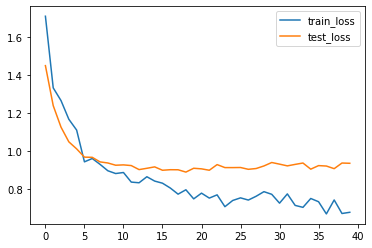

In [ ]:
# some plots
plt.plot(train_losses, label="train_loss")
plt.plot(test_losses, label="test_loss")
plt.legend()
plt.show()

In [ ]:
torch.save(model, os.path.join(translation_path, f"translation_attention_{NUM_SAMPLES}.pth"))
#torch.save(model, os.path.join(translation_path, "translation_attention_train_test.pth"))

In [ ]:
model.eval()

Seq2Seq(
  (encoder): Encoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (embedding): Embedding(10664, 100)
    (rnn): LSTM(100, 256, bidirectional=True)
    (fc_hidden): Linear(in_features=512, out_features=256, bias=True)
    (fc_cell): Linear(in_features=512, out_features=256, bias=True)
  )
  (decoder): Decoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (embedding): Embedding(17502, 100)
    (rnn): LSTM(612, 256)
    (energy): Linear(in_features=768, out_features=1, bias=True)
    (softmax): Softmax(dim=0)
    (relu): ReLU()
    (fc): Linear(in_features=256, out_features=17502, bias=True)
  )
)

In [ ]:
def decode_sequence(input_seq):
    # encode the input as state vectors.
    input_seq = input_seq.to(device)
    with torch.no_grad():
        encoder_states, h, c = encoder_net(input_seq)

        # generate empty target seq of length 1
        target_seq = torch.zeros(1).int().to(device)

        # populate the first character of target sequence with the start character
        target_seq[0] = word2idx_fr[bos]

        # if we get this we break
        eos_idx = word2idx_fr[eos]

        # create translation
        output_sentence = []
        for _ in range(max_len_target):
            output_tokens, h, c = decoder_net(target_seq, encoder_states, h, c)

            # get next word
            idx = output_tokens.argmax(1).item()

            # end of sentence EOS
            if eos_idx == idx:
                break

            word = ""
            if idx > 0:
                word = idx2word_trans[idx]
                output_sentence.append(word)

            # update the decoder input
            # which is just the word just generated
            target_seq[0] = idx

        return " ".join(output_sentence)

In [ ]:
#from nltk.translate import bleu
import nltk.translate.bleu_score as bleu

### Translation for train set

In [ ]:
while True:
    # do some translation for training data
    i = np.random.choice(len(train_inputs))
    #input_seq = encoder_inputs[i : i + 1]
    input_seq, _, _ = train_dataset[i]
    input_seq = input_seq.unsqueeze(1)
    #input_seq = torch.from_numpy(input_seq).to(device).permute(1,0)
    translation = decode_sequence(input_seq)
    print("_")
    print("Input:", train_inputs[i])
    print("True Translation:", train_targets[i])
    print("Predicted Translation:", translation)
    pred_translation = word_tokenize(translation)
    true_translation = word_tokenize(train_targets[i])
    if len(translation) > 0:
        print("BLEU Score", bleu.sentence_bleu([pred_translation], true_translation))#, smoothing_function=smoothie))

    ans = input("Continue? [Y/n]")
    if ans and ans.lower().startswith("n"):
        break


_
Input: soldiers are used to danger .
True Translation: les soldats sont habitues au danger .
Predicted Translation: les soldats sont habitues au danger .
BLEU Score 1.0
Continue? [Y/n]y


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


_
Input: where is my newspaper ?
True Translation: ou se trouve mon journal ?
Predicted Translation: ou est mon journal ?
BLEU Score 0.5081327481546147
Continue? [Y/n]y
_
Input: i was worried for nothing .
True Translation: je me suis fait du souci pour rien .
Predicted Translation: je me fis du souci pour rien .
BLEU Score 0.5133450480401704
Continue? [Y/n]y
_
Input: it s not our job to do that .
True Translation: ce n est pas notre travail de faire cela .
Predicted Translation: ce n est pas notre travail de faire cela .
BLEU Score 1.0
Continue? [Y/n]y
_
Input: whose notebook is that ?
True Translation: de qui est ce le laptop ?
Predicted Translation: a qui est ce cahier ?
BLEU Score 0.4417918226831577
Continue? [Y/n]y
_
Input: tom is opening the box .
True Translation: tom ouvre la boite .
Predicted Translation: tom ouvre la boite .
BLEU Score 1.0
Continue? [Y/n]y
_
Input: don t tell anybody .
True Translation: ne le dis a personne !
Predicted Translation: ne le dis a personne !
BLEU

### Translation for test set

In [ ]:
while True:
    # do some translation for testing data
    i = np.random.choice(len(test_inputs))
    #input_seq = encoder_inputs[i : i + 1]
    input_seq, _, _ = test_dataset[i]
    input_seq = input_seq.unsqueeze(1)
    #input_seq = torch.from_numpy(input_seq).to(device).permute(1,0)
    translation = decode_sequence(input_seq)
    print("_")
    print("Input:", test_inputs[i])
    print("True Translation:", test_targets[i])
    print("Predicted Translation:", translation)
    pred_translation = word_tokenize(translation)
    true_translation = word_tokenize(test_targets[i])
    if len(translation) > 0:
        print("BLEU Score", bleu.sentence_bleu([pred_translation], true_translation))#, smoothing_function=smoothie))

    ans = input("Continue? [Y/n]")
    if ans and ans.lower().startswith("n"):
        break


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


_
Input: no one wants to look like a fool .
True Translation: personne ne veut passer pour un idiot .
Predicted Translation: personne ne veut voir un idiot .
BLEU Score 0.6147881529512643
Continue? [Y/n]


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


_
Input: be quiet or the baby will wake up .
True Translation: reste calme sinon le bebe va se reveiller .
Predicted Translation: soyez calme le bebe le bebe se coucher du bebe .
BLEU Score 0.41105458056789007
Continue? [Y/n]
_
Input: the car has a new engine .
True Translation: la voiture est equipee d un nouveau moteur .
Predicted Translation: la voiture a un nouveau volant .
BLEU Score 0.6104735835807844
Continue? [Y/n]
_
Input: he drank beer .
True Translation: il a bu de la biere .
Predicted Translation: il but de la biere .
BLEU Score 0.4347208719449914
Continue? [Y/n]
_
Input: i wish it would happen more often .
True Translation: j aimerais que ca se produise plus souvent .
Predicted Translation: j aimerais que ca arrive souvent plus souvent .
BLEU Score 0.43167001068522526
Continue? [Y/n]
_
Input: i don t know who you are .
True Translation: j ignore qui vous etes .
Predicted Translation: je ne sais pas qui vous etes .
BLEU Score 0.36409302398068727
Continue? [Y/n]
_
Input: don

### BLEU scores

In [ ]:
def evaluate(input_texts, target_texts, translation_dataset, mode="train"):
    score = 0
    for i in range(len(input_texts)):
        input_seq, _, _ = translation_dataset[i]
        input_seq = input_seq.unsqueeze(1)
        #input_seq = torch.from_numpy(input_seq).to(device).permute(1,0)
        translation = decode_sequence(input_seq)
        pred_translation = word_tokenize(translation)
        true_translation = word_tokenize(target_texts[i])
        if len(translation) > 0:
            score += bleu.sentence_bleu([pred_translation], true_translation)#, smoothing_function=smoothie))

    score = 100 * score / len(input_texts)
    print("BLEU score on" + mode + " set:", score)
    return score 



In [ ]:
# evaluation train_data
train_score = evaluate(train_inputs, train_targets, train_dataset)

# evaluation test_data
test_score = evaluate(test_inputs, test_targets, test_dataset, mode="test")

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU score ontrain set: 75.79947836708762
BLEU score ontest set: 61.62797747223698


# END

In [ ]:
# plt.switch_backend('agg')
# import matplotlib.ticker as ticker

# def showAttention(input_sentence, output_words, attentions):
#     # Set up figure with colorbar
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     cax = ax.matshow(attentions.numpy(), cmap='bone')
#     fig.colorbar(cax)

#     # Set up axes
#     ax.set_xticklabels([''] + input_sentence.split(' ') +
#                        ['<EOS>'], rotation=90)
#     ax.set_yticklabels([''] + output_words)

#     # Show label at every tick
#     ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
#     ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

#     plt.show()